[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/tutorials/zh_cn/beginner/mindspore_dataset.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/tutorials/zh_cn/beginner/mindspore_dataset.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/source_zh_cn/beginner/dataset.ipynb)

[基本介绍](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/introduction.html) || [快速入门](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/quick_start.html) || [张量 Tensor](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/tensor.html) || **数据集 Dataset** || [数据变换 Transforms](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/transforms.html) || [网络构建](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/model.html) || [函数式自动微分](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/autograd.html) || [模型训练](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/train.html) || [保存与加载](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/save_load.html) || [使用静态图加速](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/accelerate_with_static_graph.html)

# 数据集 Dataset

数据是深度学习的基础，高质量的数据输入将在整个深度神经网络中起到积极作用。MindSpore提供基于Pipeline的[数据引擎](https://www.mindspore.cn/docs/zh-CN/master/design/data_engine.html)，通过[数据集（Dataset）](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/dataset.html)和[数据变换（Transforms）](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/transforms.html)实现高效的数据预处理。其中Dataset是Pipeline的起始，用于加载原始数据。`mindspore.dataset`提供了内置的文本、图像、音频等数据集加载接口，并提供了自定义数据集加载接口。

此外MindSpore的领域开发库也提供了大量的预加载数据集，可以使用API一键下载使用。本教程将分别对不同的数据集加载方式、数据集常见操作和自定义数据集方法进行详细阐述。

In [20]:
import numpy as np
from mindspore.dataset import vision
from mindspore.dataset import MnistDataset, GeneratorDataset
import matplotlib.pyplot as plt

## 数据集加载

我们使用**Mnist**数据集作为样例，介绍使用`mindspore.dataset`进行加载的方法。

`mindspore.dataset`提供的接口**仅支持解压后的数据文件**，因此我们使用`download`库下载数据集并解压。

In [21]:
# Download data from open datasets
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
      "notebook/datasets/MNIST_Data.zip"
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 10.8M/10.8M [00:02<00:00, 4.15MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


压缩文件删除后，直接加载，可以看到其数据类型为MnistDataset。

In [22]:
train_dataset = MnistDataset("MNIST_Data/train", shuffle=False)
print(type(train_dataset))

<class 'mindspore.dataset.engine.datasets_vision.MnistDataset'>


## 数据集迭代

数据集加载后，一般以迭代方式获取数据，然后送入神经网络中进行训练。我们可以用[create_tuple_iterator](https://www.mindspore.cn/docs/zh-CN/master/api_python/dataset/dataset_method/iterator/mindspore.dataset.Dataset.create_tuple_iterator.html)或[create_dict_iterator](https://www.mindspore.cn/docs/zh-CN/master/api_python/dataset/dataset_method/iterator/mindspore.dataset.Dataset.create_dict_iterator.html)接口创建数据迭代器，迭代访问数据。

访问的数据类型默认为`Tensor`；若设置`output_numpy=True`，访问的数据类型为`Numpy`。

下面定义一个可视化函数，迭代9张图片进行展示。

In [23]:
def visualize(dataset):
    figure = plt.figure(figsize=(4, 4))
    cols, rows = 3, 3

    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    for idx, (image, label) in enumerate(dataset.create_tuple_iterator()):
        figure.add_subplot(rows, cols, idx + 1)
        plt.title(int(label))
        plt.axis("off")
        plt.imshow(image.asnumpy().squeeze(), cmap="gray")
        if idx == cols * rows - 1:
            break
    plt.show()

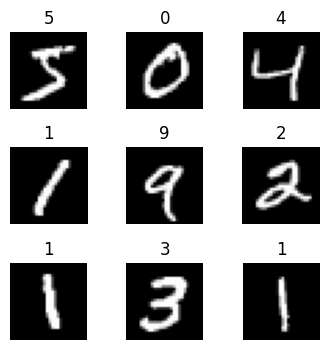

In [24]:
visualize(train_dataset)

## 数据集常用操作

Pipeline的设计理念使得数据集的常用操作采用`dataset = dataset.operation()`的异步执行方式，执行操作返回新的Dataset，此时不执行具体操作，而是在Pipeline中加入节点，最终进行迭代时，并行执行整个Pipeline。

下面分别介绍几种常见的数据集操作。

### shuffle

数据集随机`shuffle`可以消除数据排列造成的分布不均问题。

![op-shuffle](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/advanced/dataset/images/op_shuffle.png)

`mindspore.dataset`提供的数据集在加载时可配置`shuffle=True`，或使用如下操作：

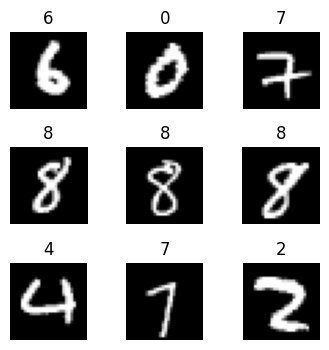

In [25]:
train_dataset = train_dataset.shuffle(buffer_size=64)

visualize(train_dataset)

### map

`map`操作是数据预处理的关键操作，可以针对数据集指定列（column）添加数据变换（Transforms），将数据变换应用于该列数据的每个元素，并返回包含变换后元素的新数据集。

> Dataset支持的不同变换类型详见[数据变换Transforms](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/transforms.html)。

In [26]:
image, label = next(train_dataset.create_tuple_iterator())
print(image.shape, image.dtype)

(28, 28, 1) UInt8


这里我们对Mnist数据集做数据缩放处理，将图像统一除以255，数据类型由uint8转为了float32。

In [27]:
train_dataset = train_dataset.map(vision.Rescale(1.0 / 255.0, 0), input_columns='image')

对比map前后的数据，可以看到数据类型变化。

In [28]:
image, label = next(train_dataset.create_tuple_iterator())
print(image.shape, image.dtype)

(28, 28, 1) Float32


### batch

将数据集打包为固定大小的`batch`是在有限硬件资源下使用梯度下降进行模型优化的折中方法，可以保证梯度下降的随机性和优化计算量。

![op-batch](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/advanced/dataset/images/op_batch.png)

一般我们会设置一个固定的batch size，将连续的数据分为若干批（batch）。

In [29]:
train_dataset = train_dataset.batch(batch_size=32)

batch后的数据增加一维，大小为`batch_size`。

In [30]:
image, label = next(train_dataset.create_tuple_iterator())
print(image.shape, image.dtype)

(32, 28, 28, 1) Float32


## 自定义数据集

`mindspore.dataset`模块提供了一些常用的公开数据集和标准格式数据集的加载API。

对于MindSpore暂不支持直接加载的数据集，可以构造自定义数据加载类或自定义数据集生成函数的方式来生成数据集，然后通过`GeneratorDataset`接口实现自定义方式的数据集加载。

`GeneratorDataset`支持通过可随机访问数据集对象、可迭代数据集对象和生成器(generator)构造自定义数据集，下面分别对其进行介绍。

### 可随机访问数据集

可随机访问数据集是实现了`__getitem__`和`__len__`方法的数据集，表示可以通过索引/键直接访问对应位置的数据样本。

例如，当使用`dataset[idx]`访问这样的数据集时，可以读取dataset内容中第idx个样本或标签。

In [31]:
# Random-accessible object as input source
class RandomAccessDataset:
    def __init__(self):
        self._data = np.ones((5, 2))
        self._label = np.zeros((5, 1))

    def __getitem__(self, index):
        return self._data[index], self._label[index]

    def __len__(self):
        return len(self._data)

In [32]:
loader = RandomAccessDataset()
dataset = GeneratorDataset(source=loader, column_names=["data", "label"])

for data in dataset:
    print(data)

[Tensor(shape=[2], dtype=Float64, value= [ 1.00000000e+00,  1.00000000e+00]), Tensor(shape=[1], dtype=Float64, value= [ 0.00000000e+00])]
[Tensor(shape=[2], dtype=Float64, value= [ 1.00000000e+00,  1.00000000e+00]), Tensor(shape=[1], dtype=Float64, value= [ 0.00000000e+00])]
[Tensor(shape=[2], dtype=Float64, value= [ 1.00000000e+00,  1.00000000e+00]), Tensor(shape=[1], dtype=Float64, value= [ 0.00000000e+00])]
[Tensor(shape=[2], dtype=Float64, value= [ 1.00000000e+00,  1.00000000e+00]), Tensor(shape=[1], dtype=Float64, value= [ 0.00000000e+00])]
[Tensor(shape=[2], dtype=Float64, value= [ 1.00000000e+00,  1.00000000e+00]), Tensor(shape=[1], dtype=Float64, value= [ 0.00000000e+00])]


In [33]:
# list, tuple are also supported.
loader = [np.array(0), np.array(1), np.array(2)]
dataset = GeneratorDataset(source=loader, column_names=["data"])

for data in dataset:
    print(data)

[Tensor(shape=[], dtype=Int64, value= 2)]
[Tensor(shape=[], dtype=Int64, value= 0)]
[Tensor(shape=[], dtype=Int64, value= 1)]


### 可迭代数据集

可迭代的数据集是实现了`__iter__`和`__next__`方法的数据集，表示可以通过迭代的方式逐步获取数据样本。这种类型的数据集特别适用于随机访问成本太高或者不可行的情况。

例如，当使用`iter(dataset)`的形式访问数据集时，可以读取从数据库、远程服务器返回的数据流。

下面构造一个简单迭代器，并将其加载至`GeneratorDataset`。

In [34]:
# Iterator as input source
class IterableDataset():
    def __init__(self, start, end):
        '''init the class object to hold the data'''
        self.start = start
        self.end = end
    def __next__(self):
        '''iter one data and return'''
        return next(self.data)
    def __iter__(self):
        '''reset the iter'''
        self.data = iter(range(self.start, self.end))
        return self

In [35]:
loader = IterableDataset(1, 5)
dataset = GeneratorDataset(source=loader, column_names=["data"])

for d in dataset:
    print(d)

[Tensor(shape=[], dtype=Int64, value= 1)]
[Tensor(shape=[], dtype=Int64, value= 2)]
[Tensor(shape=[], dtype=Int64, value= 3)]
[Tensor(shape=[], dtype=Int64, value= 4)]


### 生成器

生成器也属于可迭代的数据集类型，其直接依赖Python的生成器类型`generator`返回数据，直至生成器抛出`StopIteration`异常。

下面构造一个生成器，并将其加载至`GeneratorDataset`。

In [36]:
# Generator
def my_generator(start, end):
    for i in range(start, end):
        yield i

In [37]:
# since a generator instance can be only iterated once, we need to wrap it by lambda to generate multiple instances
dataset = GeneratorDataset(source=lambda: my_generator(3, 6), column_names=["data"])

for d in dataset:
    print(d)

[Tensor(shape=[], dtype=Int64, value= 3)]
[Tensor(shape=[], dtype=Int64, value= 4)]
[Tensor(shape=[], dtype=Int64, value= 5)]
